# 4chan Summariser

This notebook demonstrates a comprehensive analysis of recent posts from a selected 4chan board using the 4chan API. It focuses on scraping the latest discussions and extracting insights to create a word cloud of the most frequently mentioned terms. Additionally, the notebook employs a Hugging Face language model to summarise the content.

The primary goal is to analyze sentiment and trends within the cryptocurrency community on 4chan's Business and Finance board. However, the approach can be extended to other topics and boards. By integrating these insights with various trading strategies, users can enhance their understanding of market sentiment and potentially improve their trading decisions.

## Credits

This notebook references [bizproject](https://github.com/dylanbud/bizproject) repository by [dylanbud](https://github.com/dylanbud). I want to extend my sincere gratitude to this user for creating this valuable resource. The original work provided the core portion of what I built upon. I have made modifications to the data handling and the Large Language Model (LLM) summarisation.

## Prepare your Environment

Ensure that the correct kernel is selected for this notebook. If you are following the instruction in *README.md*, the kernel is 'social-media-analysis'. To check, click on 'Kernel' at the top bar, select 'Change Kernel...' and select the correct kernel. For convenience, ensure that 'Always start the preferred kernel' is ticked. Click 'Select' to confirm the setting.

Install the environment's dependencies using the command below. After installation, restart the kernel to use the updated packages. To restart, click on 'Kernel' at the top bar and select 'Restart Kernel' and click on 'Restart'. Please skip this step if you have already done it.

In [ ]:
pip install -r requirements.txt

In [ ]:
!python -m spacy download en_core_web_sm

In [1]:
from datetime import datetime
import pandas as pd
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
import spacy
from collections import Counter
from nltk.probability import FreqDist
import warnings
from data_manager import *
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

pd.set_option('display.max_rows', None)
warnings.filterwarnings("ignore")

## Load data

### Inputs

In [2]:
##### INPUTS #####
# Select data source. Options: ['4chan', 'hugging_face'].
source = '4chan'

# If source == '4chan', select board.
board = 'biz'

# Start date and end date of data.
start_date = '2024-08-06'
end_date = '2024-08-06'
##################

In [3]:
base_dir_path = './saved_data'
merged_df = load_df_range(base_dir_path, source, board, start_date, end_date)
merged_df.head(10)

,Date Time,Name,ID,Thread Subject,Comment,Thread Post Number,Post Number,Thread Replies,Is Thread OP
0,2024-08-06 00:34:57,Anonymous,CjeCMiT6,Bbbyq - Ryan Cohen edition,member holly etlin makes claim that what happe...,58830212,58830212,87,Yes
1,2024-08-06 00:35:58,Anonymous,CjeCMiT6,Bbbyq - Ryan Cohen edition,>who is nick lewin?>he was tasked with prosecu...,58830212,58830223,87,No
2,2024-08-06 01:00:22,Anonymous,hdxPzjDz,/XMR/ Monero General,i'm not surprised it's algorithmic stablecoin ...,58827383,58830450,106,No
3,2024-08-06 01:34:12,Anonymous,T80DfTcG,Bbbyq - Ryan Cohen edition,bless the baker!,58830212,58830757,87,No
4,2024-08-06 01:35:32,Anonymous,17AfPtqs,Bbbyq - Ryan Cohen edition,what about intel,58830212,58830773,87,No
5,2024-08-06 01:35:58,Anonymous,JtdDVI+C,/smg/ Intel,intel a buy here?,58830779,58830779,302,Yes
6,2024-08-06 01:40:00,Anonymous,lvTXVros,/smg/ Intel,good god no lol,58830779,58830808,302,No
7,2024-08-06 01:41:23,Anonymous,ROBCW0dT,/smg/ Intel,buy in the middle of the next fab cycle.t. fri...,58830779,58830815,302,No
8,2024-08-06 01:41:52,Anonymous,SyP9Qa8/,/smg/ Intel,i need help. we need help.i’m praying. i’m act...,58830779,58830818,302,No
9,2024-08-06 01:51:28,Anonymous,x3kmEi6x,/smg/ Intel,it might dead cat bounce a bit with the broade...,58830779,58830901,302,No


## Append all comments together to a string

In [4]:
comment_list = merged_df['Comment'].tolist()
corp_string = ' '.join(map(str, comment_list))

corp_string = corp_string.strip()

## Token Classification and Frequency Analysis

In [5]:
nlp = spacy.load("en_core_web_sm")
doc = nlp(corp_string)
STOPWORDS = ["coin", "shit", "time", "year", "day", "fuck", "life", "way", "guys", "%", "days", "bros", "pic", "bull", "dump", "bags", "man", "rugs", "run", "lot", "fees", "home", "guy", "idea", "k", "moon", "pump", "bag", "scam"]

# all tokens that arent stop words or punctuations
words = [token.text
         for token in doc
         if not token.is_stop and not token.is_punct and len(token) >= 3]

# noun tokens that arent stop words or punctuations
nouns = [token.text
         for token in doc
         if (not token.is_stop and
             not token.is_punct and
             token.pos_ == "NOUN")]

adjectives = [token.text
         for token in doc
         if (not token.is_stop and
             not token.is_punct and
             token.pos_ == "ADJ")]

verbs = [token.text
         for token in doc
         if (not token.is_stop and
             not token.is_punct and
             token.pos_ == "VERB")]

propn = [token.text
         for token in doc
         if (not token.is_stop and
             not token.is_punct and
             token.pos_ == "PROPN")]
             
adposition = [token.text
         for token in doc
         if (not token.is_stop and
             not token.is_punct and
             token.pos_ == "ADP")]

adverb = [token.text
         for token in doc
         if (not token.is_stop and
             not token.is_punct and
             token.pos_ == "ADV")]
pronoun = [token.text
         for token in doc
         if (not token.is_stop and
             not token.is_punct and
             token.pos_ == "PRON")]

determiner = [token.text
         for token in doc
         if (not token.is_punct and
             token.pos_ == "DET")]

conjunction = [token.text
         for token in doc
         if (token.pos_ == "CONJ")]

potential_coins = [token.text
         for token in doc
         if (not token.is_stop 
         and token.pos_ == "NOUN"
         and len(token) <= 4)]


# ```ADJ: adjective, e.g. big, old, green, incomprehensible, first
# ADP: adposition, e.g. in, to, during
# ADV: adverb, e.g. very, tomorrow, down, where, there
# AUX: auxiliary, e.g. is, has (done), will (do), should (do)
# CONJ: conjunction, e.g. and, or, but
# CCONJ: coordinating conjunction, e.g. and, or, but
# DET: determiner, e.g. a, an, the
# INTJ: interjection, e.g. psst, ouch, bravo, hello
# NOUN: noun, e.g. girl, cat, tree, air, beauty
# NUM: numeral, e.g. 1, 2017, one, seventy-seven, IV, MMXIV
# PART: particle, e.g. ’s, not,
# PRON: pronoun, e.g I, you, he, she, myself, themselves, somebody
# PROPN: proper noun, e.g. Mary, John, London, NATO, HBO
# PUNCT: punctuation, e.g. ., (, ), ?
# SCONJ: subordinating conjunction, e.g. if, while, that
# SYM: symbol, e.g. $, %, §, ©, +, −, ×, ÷, =, :), 😝
# VERB: verb, e.g. run, runs, running, eat, ate, eating
# X: other, e.g. sfpksdpsxmsa
# SPACE: space, e.g.````

# most common tokens
word_freq = Counter(words)
common_words = word_freq.most_common(100)

# most common noun tokens
noun_freq = Counter(nouns)
common_nouns = noun_freq.most_common(100)

# most common adjective tokens
adj_freq = Counter(adjectives)
common_adjectives = adj_freq.most_common(100)

# most common verb tokens
verb_freq = Counter(verbs)
common_verbs = verb_freq.most_common(100)

# most common propositions
prop_freq = Counter(propn)
common_props = prop_freq.most_common(100)

# most common adpostions
adposition_freq = Counter(propn)
common_adpositions = adposition_freq.most_common(100)

# most common adverbs
adverb_freq = Counter(adverb)
common_adverbs = adverb_freq.most_common(100)

# most common determiners
determiner_freq = Counter(determiner)
common_determiner = determiner_freq.most_common(100)

# most common pronouns
pronoun_freq = Counter(pronoun)
common_pronouns = pronoun_freq.most_common(100)

# most common conjunctions
conjunction_freq = Counter(conjunction)
common_conjunctions = conjunction_freq.most_common(100)

potential_coins_freq = Counter(potential_coins)
common_potential_coins = potential_coins_freq.most_common(100)


## Potential Coins found in Posts

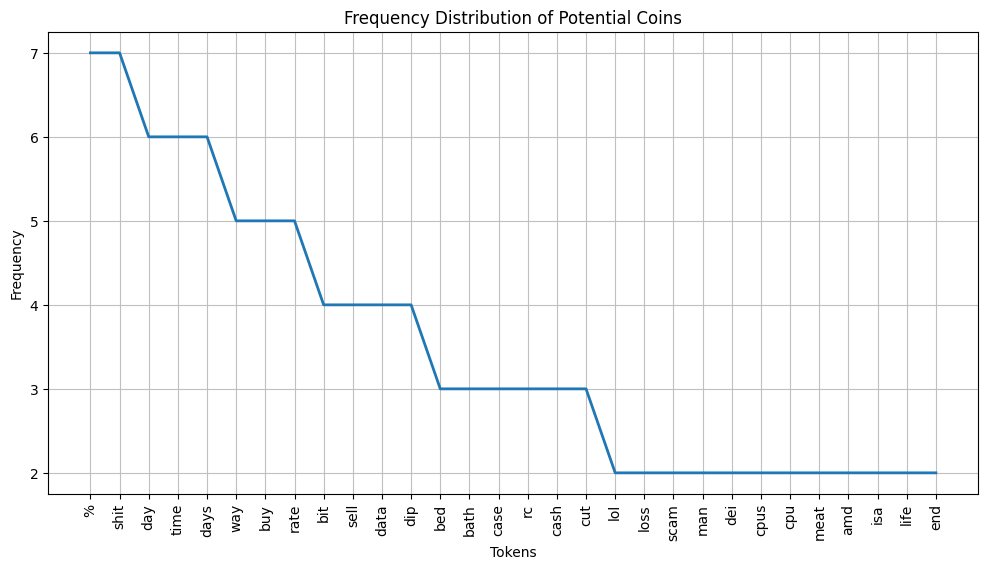

List of Frequency Distribution of Potential Coins:
[('%', 7), ('shit', 7), ('day', 6), ('time', 6), ('days', 6), ('way', 5), ('buy', 5), ('rate', 5), ('bit', 4), ('sell', 4), ('data', 4), ('dip', 4), ('bed', 3), ('bath', 3), ('case', 3), ('rc', 3), ('cash', 3), ('cut', 3), ('lol', 2), ('loss', 2), ('scam', 2), ('man', 2), ('dei', 2), ('cpus', 2), ('cpu', 2), ('meat', 2), ('amd', 2), ('isa', 2), ('life', 2), ('end', 2), ('*', 1), ('uno', 1), ('exit', 1), ('game', 1), ('dtc', 1), ('rule', 1), ('pump', 1), ('hand', 1), ('help', 1), ('cat', 1), ('year', 1), ('usd', 1), ('baby', 1), ('load', 1), ('.', 1), ('yen', 1), ('bias', 1), ('apps', 1), ('step', 1), ('bots', 1), ('mess', 1), ('xmr', 1), ('plan', 1), ('dude', 1), ('lie', 1), ('love', 1), ('lot', 1), ('bro', 1), ('lab', 1), ('food', 1), ('sovl', 1), ('girl', 1), ('coof', 1), ('set', 1), ('x86', 1), ('turn', 1), ('bull', 1), ('eos', 1), ('rn', 1), ('tlt', 1), ('cap', 1), ('week', 1), ('bbby', 1), ('boat', 1), ('tax', 1), ('bond', 1), ('s

In [6]:
print("\n")

fdist = FreqDist(potential_coins)

plt.figure(figsize=(12, 6))
fdist.plot(30, cumulative=False)  # Adjust the number of bins as needed
plt.title('Frequency Distribution of Potential Coins')
plt.xlabel('Tokens')
plt.ylabel('Frequency')
plt.show()

print("List of Frequency Distribution of Potential Coins:")
print(common_potential_coins)

print("\n")

## Wordcloud

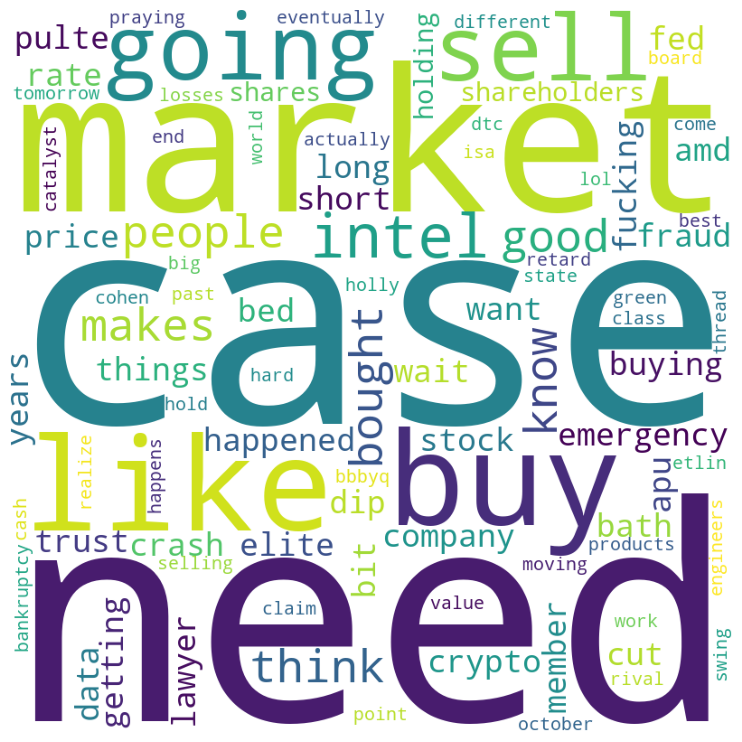

In [7]:
print("\n")

# Wordcloud creation
now = datetime.now()
dt_string = now.strftime("%m%d-%Y%H%M%S")

# Get all common words, map to string for wordcloud
wordcloud_common = []
for i in range(0,100):
    word = common_words[i][0]
    wordcloud_common.append(word)

wordcloud_string = ' '.join(map(str, wordcloud_common))

wordcloud = WordCloud(width = 800, height = 800,
                background_color = 'white',
                stopwords=STOPWORDS,
                min_font_size = 10).generate(wordcloud_string)
 
# plot the WordCloud image    
                  
plt.figure(figsize = (10, 10), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 10)
plt.savefig(board + "" + dt_string + "" + ".png", format="png")
plt.show()

print("\n")

## Remove Bad Words in text

This may be helpful because LLM are usually trained on preprocessed text data with inappropriate or offensive words removed or filtered out.

In [8]:
print("\n")

# 'BAD WORDS' list
# https://github.com/web-mech/badwords
url = ('https://raw.githubusercontent.com/web-mech/badwords/master/lib/lang.json')
data = get_jsonparsed_data(url)

badwords = []
for i in range(0, len(data['words'])):
    word  = data['words'][i]
    badwords.append(word)

text_to_summarise = corp_string
for badword in badwords:
        text_to_summarise = text_to_summarise.replace(badword,""*len(badword))

print("Processed text to be used for LLM Summarisation:\n")
print(text_to_summarise)

original_text_to_summarise = text_to_summarise

print("\n")



Processed text to be used for LLM Summarisation:

member holly etlin makes claim that what happened to bed bath & beyond has not happened except in cases of fraud buyback fraud explained companies state that they face bankruptcy...but then *suddenly* do a 180 "reverse uno", squeeze short sellers and bring riches to shareholders? can bbbyq exit chapter 11 in a way that benefits shareholders game: dtc and nscc are ed as the dtc just proved shareholders should directly register shares (drs) "cl action" case against rccase number: 1:22-cv-02541-tnm cohen's 16b short swing rule was dismissed the other day. but his "pump and dump" case is still active and may be holding things up.previous thread: >who is nick lewin?>he was tasked with prosecuting 3 leading members of al-qaeda was the lawyer for hunter biden during the probe into his activities is the lawyer in charge of eventually releasing the epstein doents and keeping them away from people like alan dershowitz in the meantime (alan is t

## LLM Summarisation

This section uses an open-source LLM model [Pegasus-finetuned-tweet-summary](https://huggingface.co/rittik9/Pegasus-finetuned-tweet-summary) to summarise the chunk of text. Due to the model's limitation on the maximum number of input tokens, text summarization is performed using batch processing. This process may take some time to complete. If it runs too slow, consider reducing the amount of data to load (eg. by narrowing the range between *start_date* and *end_date*) above or reducing the text size to speed up execution.

In [9]:
print("\n")

text_to_summarise = original_text_to_summarise[:]

print("Reduced text to be used for LLM Summarisation:\n")
print(text_to_summarise)

print("\n")



Reduced text to be used for LLM Summarisation:

member holly etlin makes claim that what happened to bed bath & beyond has not happened except in cases of fraud buyback fraud explained companies state that they face bankruptcy...but then *suddenly* do a 180 "reverse uno", squeeze short sellers and bring riches to shareholders? can bbbyq exit chapter 11 in a way that benefits shareholders game: dtc and nscc are ed as the dtc just proved shareholders should directly register shares (drs) "cl action" case against rccase number: 1:22-cv-02541-tnm cohen's 16b short swing rule was dismissed the other day. but his "pump and dump" case is still active and may be holding things up.previous thread: >who is nick lewin?>he was tasked with prosecuting 3 leading members of al-qaeda was the lawyer for hunter biden during the probe into his activities is the lawyer in charge of eventually releasing the epstein doents and keeping them away from people like alan dershowitz in the meantime (alan is the

In [14]:
tokenizer = AutoTokenizer.from_pretrained(
    "rittik9/Pegasus-finetuned-tweet-summary")
model = AutoModelForSeq2SeqLM.from_pretrained(
    "rittik9/Pegasus-finetuned-tweet-summary")

print("\n")

def generate_summary(text, max_batches_of_summarised_text=5):

    final_summarise_flag = False
    batch_count = 1

    print("Generating the summary... Please wait...\n")

    while not final_summarise_flag:
        summarised_text_list = []
        inputs = tokenizer([text], return_tensors='pt')
        all_input_ids = inputs.input_ids
        stride = 128
        input_ids_in_batches = []

        for i in range(0, all_input_ids.shape[-1], stride):
            batch_input_ids = all_input_ids[:, i:i + 512]
            input_ids_in_batches.append(batch_input_ids)

            if (i + 512) >= all_input_ids.shape[-1]:
                break

        no_of_batches = len(input_ids_in_batches)

        if no_of_batches <= max_batches_of_summarised_text:
            final_summarise_flag = True

        for batch_input_ids in input_ids_in_batches:
            output = model.generate(batch_input_ids, max_new_tokens=200, do_sample=True)
            batch_summarised_text = tokenizer.decode(output[0],
                                                     skip_special_tokens=True)
            batch_summarised_text = batch_summarised_text.replace(
                'tweets', 'posts')
            last_fullstop_index = batch_summarised_text.rfind('.')

            if last_fullstop_index != len(batch_summarised_text) - 1:
                batch_summarised_text = batch_summarised_text[:last_fullstop_index + 1]

            if final_summarise_flag:
                print("Batch Summarised Text {}:".format(batch_count))
                print(batch_summarised_text)
                print("\n")
                batch_count += 1

            summarised_text_list.append(batch_summarised_text)

        text = ' '.join(summarised_text_list)

    return text


summarised_text = generate_summary(text_to_summarise)

print("Final Summarised Text:")
print(summarised_text)

print("\n")

Token indices sequence length is longer than the specified maximum sequence length for this model (3806 > 1024). Running this sequence through the model will result in indexing errors




Generating the summary... Please wait...

Batch Summarised Text 1:
This set of posts discusses a variety of topics, including the stock market, buyback fraud, and Intel. It appears that the overall sentiment is one of caution, with investors being cautious and taking a wait and see approach. It also mentions the importance of macro bias in the Forex market, the current status of the cryptocurrency market, the difficulty of storing money, the low volatility of the market, and the potential for increased scrutiny. Finally, it discusses the recent market crash and how people are reacting to it.


Batch Summarised Text 2:
This set of posts appears to be a conversation between people discussing the current state of the world and their opinions on it. They are discussing the potential for the US government to spy on people, the economic benefits of such a move, the merits of Intel processors and AMD products, and the cross licensing agreement between AMD and Intel. They are also discussing